# Análisis de Machine Learning - Torre de Gradiente
# Predicción de flujo de calor del suelo usando variables meteorológicas

In [54]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



## 1. CARGA Y ANÁLISIS EXPLORATORIO DE DATOS


In [55]:
# Cargar datos
CSV_PATH = "IGP_EstacionTorreGradiente_2018-2025_Dataset_0.csv"

try:
    df = pd.read_csv(CSV_PATH)
    print(f"Datos cargados: {df.shape[0]} filas x {df.shape[1]} columnas")
except Exception as e:
    print(f"Error al cargar datos: {e}")


Datos cargados: 54803 filas x 27 columnas


In [56]:
# Vistazo a los datos
df.head()


,FECHA_CORTE,UBIGEO,year,month,day,hour,temp_n1,temp_n2,temp_n3,temp_n4,...,RH_n6,wind_n1,wind_n2,wind_n3,wind_n4,wind_n5,wind_n6,dir_wind_01,dir_wind_02,soil_heat
0,20250530,120904,2018,5,15,14,20.07117,19.61817,19.34850,19.46133,...,24.84250,1.27615,1.51282,1.63960,1.71803,1.74843,1.73988,137.73583,130.83133,-59.62925
1,20250530,120904,2018,5,15,15,20.02767,19.67267,19.47667,19.56783,...,23.91850,1.49800,1.81533,2.00695,2.13998,2.31407,2.38310,121.96283,125.40717,-48.84940
2,20250530,120904,2018,5,15,16,17.48100,17.61083,17.65217,17.85100,...,34.13567,1.67402,2.57707,3.06792,3.31683,3.61100,3.69643,80.40917,82.49550,-29.88178
3,20250530,120904,2018,5,15,17,14.95833,15.22533,15.36433,15.60517,...,45.07883,1.10408,1.98747,2.41770,2.64992,2.78088,2.93363,182.83367,178.57800,-10.57230
4,20250530,120904,2018,5,15,18,12.82483,12.93933,13.02117,13.28333,...,55.58850,2.40263,3.54670,4.24970,4.78075,5.08188,5.33525,326.46833,325.56333,-0.51723


In [57]:
# Estadísticas descriptivas
excluded_cols = ['FECHA_CORTE', 'UBIGEO', 'year', 'month', 'day', 'hour']
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in excluded_cols]
display(df[numeric_cols].describe())


,temp_n1,temp_n2,temp_n3,temp_n4,temp_n5,temp_n6,RH_n1,RH_n2,RH_n3,RH_n4,...,RH_n6,wind_n1,wind_n2,wind_n3,wind_n4,wind_n5,wind_n6,dir_wind_01,dir_wind_02,soil_heat
count,54453.000000,53408.000000,53408.000000,53408.000000,53408.000000,53408.000000,54453.000000,54098.000000,54098.000000,54098.000000,...,54098.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,40933.000000
mean,10.478046,10.648774,10.843542,11.892649,10.925183,12.015843,62.075935,59.957068,58.537087,58.482781,...,57.829748,1.080889,1.606954,1.884061,2.012042,2.141392,2.177816,189.287425,187.242088,121.639373
std,5.271766,4.855957,4.474143,4.182968,4.195090,4.020389,22.388283,21.575360,20.757645,20.323354,...,19.952918,1.019282,1.228453,1.417195,1.518973,1.611564,1.660618,73.472624,72.612254,643.164363
min,-15.982300,-15.369900,-14.502650,-0.886980,-14.257320,-0.683330,-2.062720,-2.048920,-1.812180,2.736870,...,2.640670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.735400,17.072830,-4000.966440
25%,7.106780,7.478980,7.812705,8.914085,8.044665,9.114128,45.079000,43.745750,43.238293,43.592830,...,43.345540,0.332000,0.806900,0.981480,1.032800,1.111900,1.120200,129.558330,129.951830,-26.467520
50%,10.142670,10.324665,10.471330,11.454330,10.553670,11.582915,63.889000,61.278250,59.683500,59.575500,...,58.842250,0.817670,1.366770,1.623570,1.655630,1.731570,1.728880,177.878330,176.650000,16.867050
75%,14.524500,14.314000,14.189373,15.045378,14.019372,15.020795,81.683000,78.108295,75.143790,74.282958,...,72.916585,1.486920,2.010270,2.357350,2.485620,2.614180,2.657820,264.841670,259.575000,29.979150
max,24.660500,24.746830,24.796670,25.068170,24.849000,25.236670,99.690000,99.826670,99.630000,100.000000,...,99.888330,8.765720,12.848500,15.039330,16.229830,16.855000,16.996500,333.640000,337.406670,4132.341610


In [58]:
# Valores faltantes
print("\nValores faltantes:")

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_data.index,
    'Valores Faltantes': missing_data.values,
    'Porcentaje': missing_percent.values
})
missing_df = missing_df[missing_df['Valores Faltantes'] > 0].sort_values('Porcentaje', ascending=False)

if not missing_df.empty:
    display(missing_df.sort_index())
else:
    print("No hay valores faltantes")



Valores faltantes:


,Columna,Valores Faltantes,Porcentaje
6,temp_n1,350,0.638651
7,temp_n2,1395,2.545481
8,temp_n3,1395,2.545481
9,temp_n4,1395,2.545481
10,temp_n5,1395,2.545481
11,temp_n6,1395,2.545481
12,RH_n1,350,0.638651
13,RH_n2,705,1.286426
14,RH_n3,705,1.286426
15,RH_n4,705,1.286426


## 2. VISUALIZACIONES EXPLORATORIAS

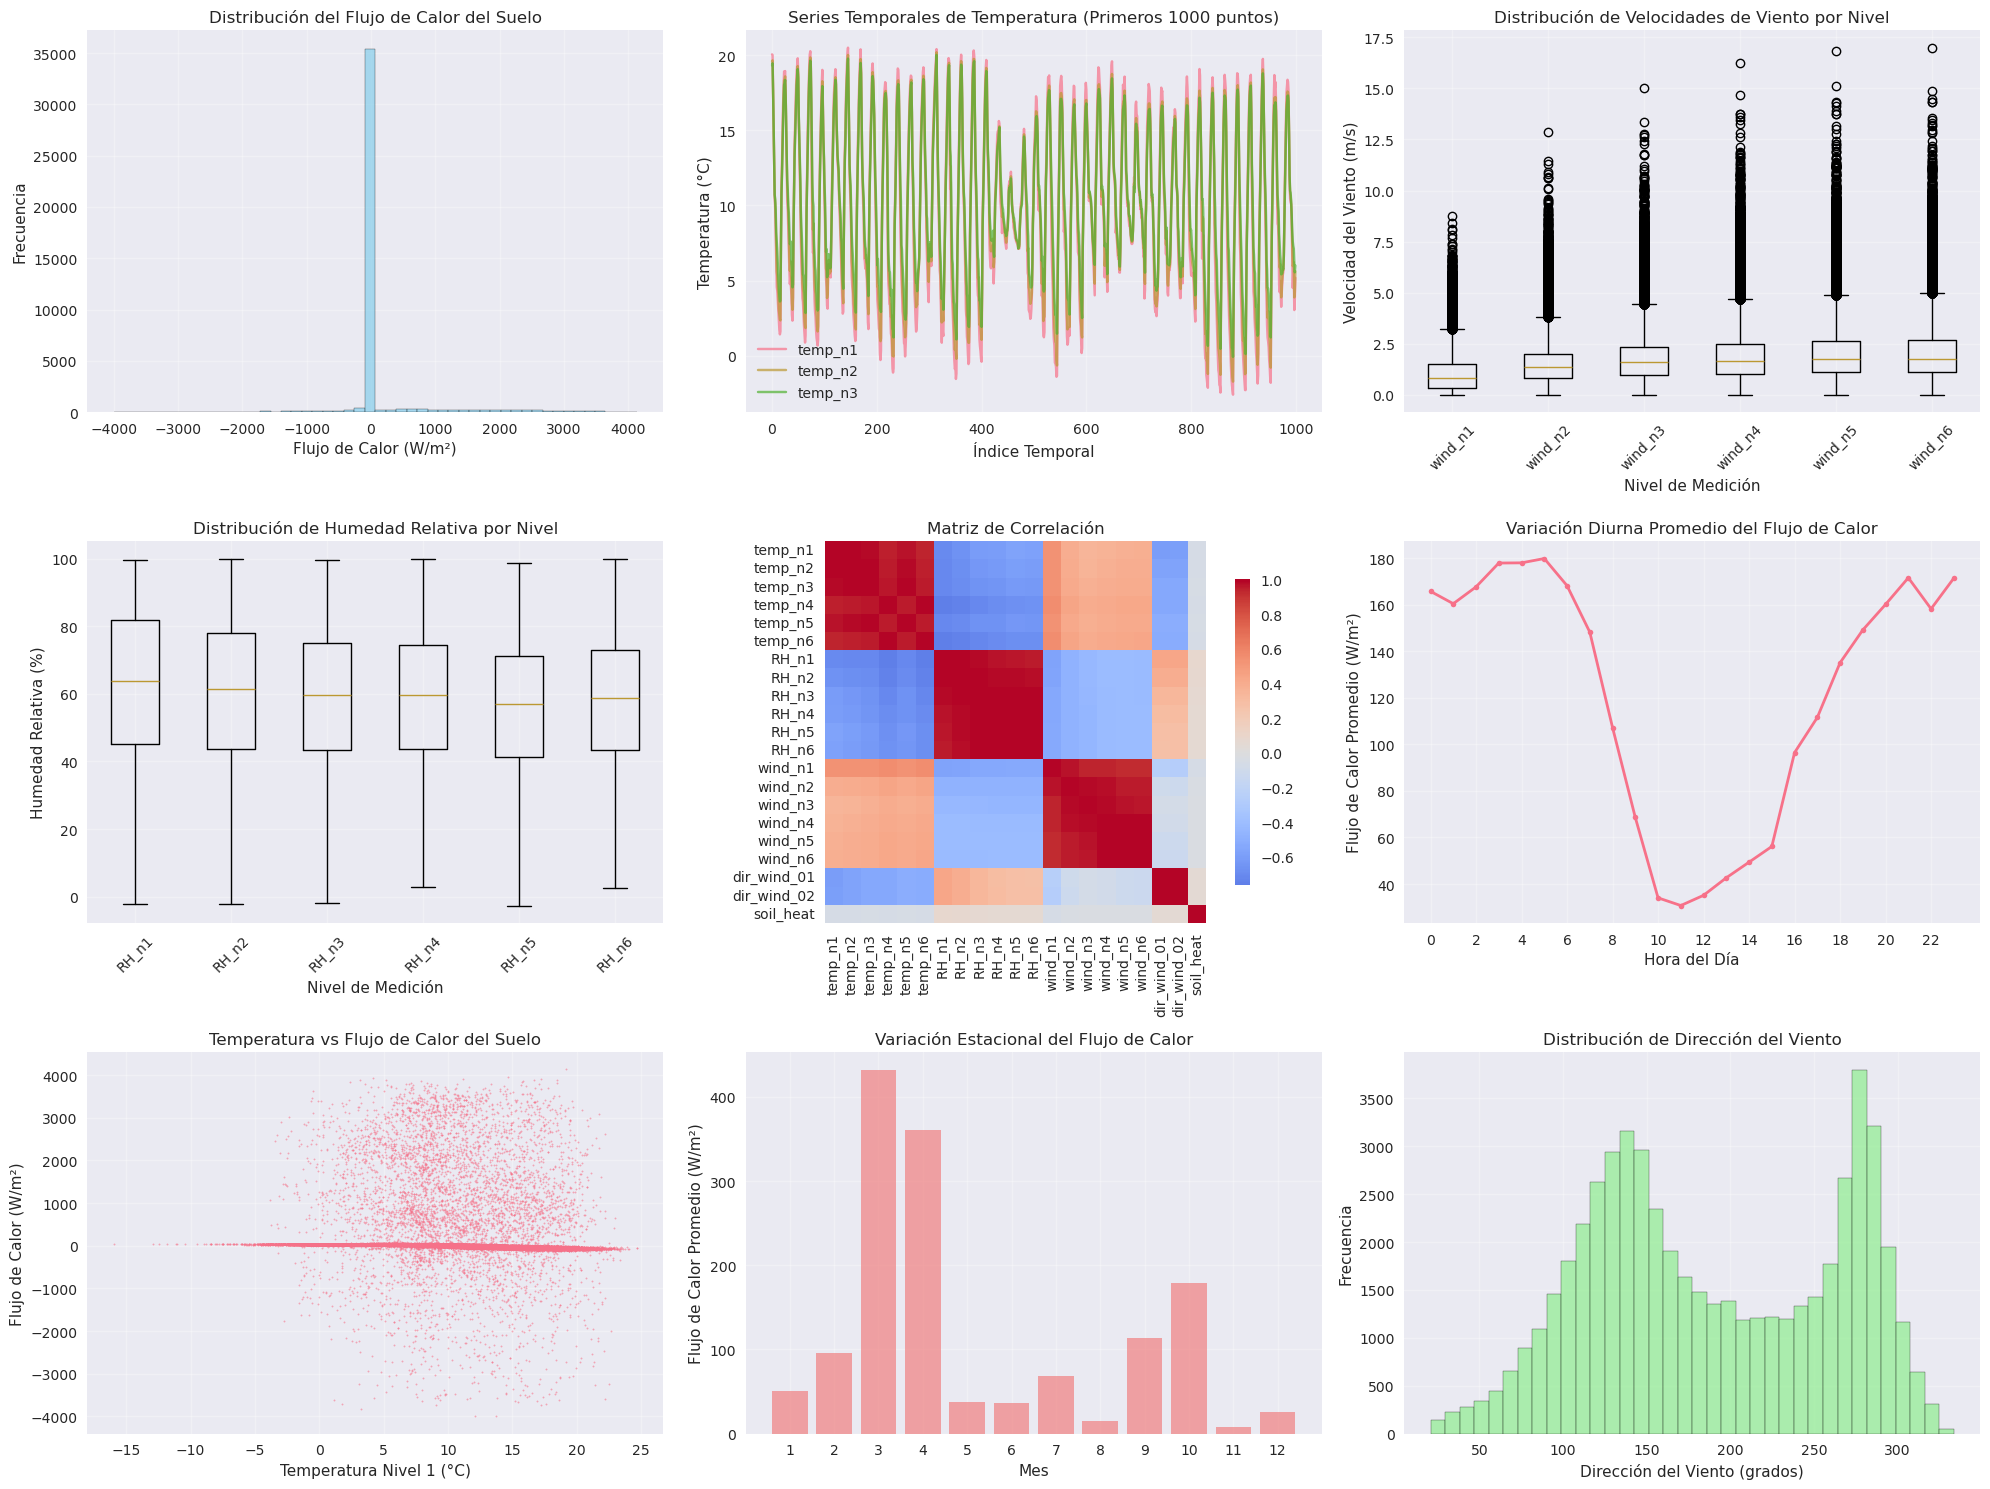

In [59]:
fig = plt.figure(figsize=(20, 15))

# Distribución de la variable objetivo (soil_heat)
if 'soil_heat' in df.columns:
    plt.subplot(3, 3, 1)
    plt.hist(df['soil_heat'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribución del Flujo de Calor del Suelo')
    plt.xlabel('Flujo de Calor (W/m²)')
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)

# Series temporales de temperatura
temp_cols = [col for col in df.columns if 'temp_n' in col]
if temp_cols:
    plt.subplot(3, 3, 2)
    for col in temp_cols[:3]:
        if col in df.columns:
            plt.plot(df.index[:1000], df[col][:1000], alpha=0.7, label=col)
    plt.title('Series Temporales de Temperatura (Primeros 1000 puntos)')
    plt.xlabel('Índice Temporal')
    plt.ylabel('Temperatura (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Boxplot de velocidades de viento
wind_cols = [col for col in df.columns if 'wind_n' in col]
if wind_cols:
    plt.subplot(3, 3, 3)
    wind_data = [df[col].dropna().values for col in wind_cols if col in df.columns]
    plt.boxplot(wind_data, labels=wind_cols)
    plt.title('Distribución de Velocidades de Viento por Nivel')
    plt.xlabel('Nivel de Medición')
    plt.ylabel('Velocidad del Viento (m/s)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

# Humedad relativa por nivel
rh_cols = [col for col in df.columns if 'RH_n' in col]
if rh_cols:
    plt.subplot(3, 3, 4)
    rh_data = [df[col].dropna().values for col in rh_cols if col in df.columns]
    plt.boxplot(rh_data, labels=rh_cols)
    plt.title('Distribución de Humedad Relativa por Nivel')
    plt.xlabel('Nivel de Medición')
    plt.ylabel('Humedad Relativa (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

# Correlación entre variables
plt.subplot(3, 3, 5)
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
           square=True, fmt='.2f', cbar_kws={'shrink': .8})
plt.title('Matriz de Correlación')

# Variación diurna promedio
if 'hour' in df.columns and 'soil_heat' in df.columns:
    plt.subplot(3, 3, 6)
    hourly_avg = df.groupby('hour')['soil_heat'].mean()
    plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=4)
    plt.title('Variación Diurna Promedio del Flujo de Calor')
    plt.xlabel('Hora del Día')
    plt.ylabel('Flujo de Calor Promedio (W/m²)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24, 2))

# Scatter plot: Temperatura vs Flujo de Calor
if 'temp_n1' in df.columns and 'soil_heat' in df.columns:
    plt.subplot(3, 3, 7)
    plt.scatter(df['temp_n1'], df['soil_heat'], alpha=0.5, s=1)
    plt.title('Temperatura vs Flujo de Calor del Suelo')
    plt.xlabel('Temperatura Nivel 1 (°C)')
    plt.ylabel('Flujo de Calor (W/m²)')
    plt.grid(True, alpha=0.3)

# Variación estacional
if 'month' in df.columns and 'soil_heat' in df.columns:
    plt.subplot(3, 3, 8)
    monthly_avg = df.groupby('month')['soil_heat'].mean()
    plt.bar(monthly_avg.index, monthly_avg.values, color='lightcoral', alpha=0.7)
    plt.title('Variación Estacional del Flujo de Calor')
    plt.xlabel('Mes')
    plt.ylabel('Flujo de Calor Promedio (W/m²)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, 13))

# Distribución de dirección del viento
if 'dir_wind_01' in df.columns:
    plt.subplot(3, 3, 9)
    wind_dir = df['dir_wind_01'].dropna()
    plt.hist(wind_dir, bins=36, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Distribución de Dirección del Viento')
    plt.xlabel('Dirección del Viento (grados)')
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. PREPROCESAMIENTO DE DATOS

In [114]:
# Copia para trabajar
df_processed = df.copy()


In [115]:
# Definir variable objetivo y características
feature_cols = [col for col in df_processed.columns if col in ['FECHA_CORTE', 'UBIGEO']]

# Variables temporales
time_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
feature_cols.extend([col for col in time_features if col in df_processed.columns])

# Variables meteorológicas originales
met_features = temp_cols_available + wind_cols_available + rh_cols_available
feature_cols.extend(met_features)

# Variables de dirección del viento
wind_dir_cols = [col for col in df_processed.columns if 'dir_wind' in col]
feature_cols.extend(wind_dir_cols[:2])

# Variables derivadas
derived_features = [col for col in df_processed.columns if
                   ('gradient' in col or 'mean' in col or 'std' in col)]
feature_cols.extend(derived_features)

# Eliminar duplicados y filtrar columnas existentes
feature_cols = list(set([col for col in feature_cols if col in df_processed.columns]))


In [116]:
print(f"{X.shape[0]} muestras, {X.shape[1]} características")
print(f"Características seleccionadas: {len(feature_cols)}")
print(f"Variable objetivo: {target}")


40933 muestras, 35 características
Características seleccionadas: 22
Variable objetivo: soil_heat


In [117]:
# Preparar matrices X e y
X = df_processed[feature_cols].copy()
y = df_processed[target].copy()

# Eliminar filas con valores faltantes en la variable objetivo
valid_idx = ~y.isnull()
X = X[valid_idx]
y = y[valid_idx]

print(f"Datos después de limpieza: {X.shape[0]} muestras, {X.shape[1]} características")


Datos después de limpieza: 40933 muestras, 22 características


In [118]:
# Imputar valores faltantes en características
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=feature_cols, index=X.index)


In [119]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


In [120]:
# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [121]:
# Convertir de vuelta a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)


In [122]:
print(f"División de datos:")
print(f"- Entrenamiento: {X_train.shape[0]} muestras")
print(f"- Prueba: {X_test.shape[0]} muestras")


División de datos:
- Entrenamiento: 32746 muestras
- Prueba: 8187 muestras


## 4. ENTRENAMIENTO DE MODELOS

In [123]:
# Definir modelos
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}


In [124]:
# Almacenar resultados
results = {}
trained_models = {}

for name, model in models.items():
    print(f"Entrenando {name}...")

    # Entrenar modelo
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

    # Calcular métricas
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    # Guardar resultados
    trained_models[name] = model
    results[name] = {
        'train_mse': train_mse, 'test_mse': test_mse,
        'train_r2': train_r2, 'test_r2': test_r2,
        'train_mae': train_mae, 'test_mae': test_mae,
        'train_pred': train_pred, 'test_pred': test_pred
    }

    print(f"  R²: {test_r2:.4f} | MSE: {test_mse:.4f} | MAE: {test_mae:.4f}")



Entrenando Linear Regression...
  R²: 0.0237 | MSE: 422708.1607 | MAE: 295.2663
Entrenando Random Forest...
  R²: 0.0200 | MSE: 424296.8841 | MAE: 314.0808
Entrenando Gradient Boosting...
  R²: 0.0068 | MSE: 430025.8512 | MAE: 300.7688


## 5. EVALUACIÓN Y RESULTADOS

In [127]:
# Crear tabla de resultados
results_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'R² Train': [results[model]['train_r2'] for model in results.keys()],
    'R² Test': [results[model]['test_r2'] for model in results.keys()],
    'MSE Train': [results[model]['train_mse'] for model in results.keys()],
    'MSE Test': [results[model]['test_mse'] for model in results.keys()],
    'MAE Train': [results[model]['train_mae'] for model in results.keys()],
    'MAE Test': [results[model]['test_mae'] for model in results.keys()]
})


In [128]:
print("\nMétricas de rendimiento:")
display(results_df.round(4))

# Identificar mejor modelo
best_model_name = results_df.loc[results_df['R² Test'].idxmax(), 'Modelo']
best_r2 = results_df.loc[results_df['R² Test'].idxmax(), 'R² Test']

print(f"\nMejor modelo: {best_model_name}")
print(f"R² en prueba: {best_r2:.4f}")
print(f"MSE en prueba: {results[best_model_name]['test_mse']:.4f}")
print(f"MAE en prueba: {results[best_model_name]['test_mae']:.4f}")



Métricas de rendimiento:


,Modelo,R² Train,R² Test,MSE Train,MSE Test,MAE Train,MAE Test
0,Linear Regression,0.0224,0.0237,399653.8743,422708.1607,286.2952,295.2663
1,Random Forest,0.8616,0.0200,56586.5403,424296.8841,115.5410,314.0808
2,Gradient Boosting,0.0561,0.0068,385894.5610,430025.8512,283.4515,300.7688



Mejor modelo: Linear Regression
R² en prueba: 0.0237
MSE en prueba: 422708.1607
MAE en prueba: 295.2663


In [129]:
# Identificar mejor modelo
best_model_name = results_df.loc[results_df['R² Test'].idxmax(), 'Modelo']
best_r2 = results_df.loc[results_df['R² Test'].idxmax(), 'R² Test']

print(f"\nMejor modelo: {best_model_name}")
print(f"R² en prueba: {best_r2:.4f}")
print(f"MSE en prueba: {results[best_model_name]['test_mse']:.4f}")
print(f"MAE en prueba: {results[best_model_name]['test_mae']:.4f}")



Mejor modelo: Linear Regression
R² en prueba: 0.0237
MSE en prueba: 422708.1607
MAE en prueba: 295.2663


## VISUALIZACION DE RESULTADOS

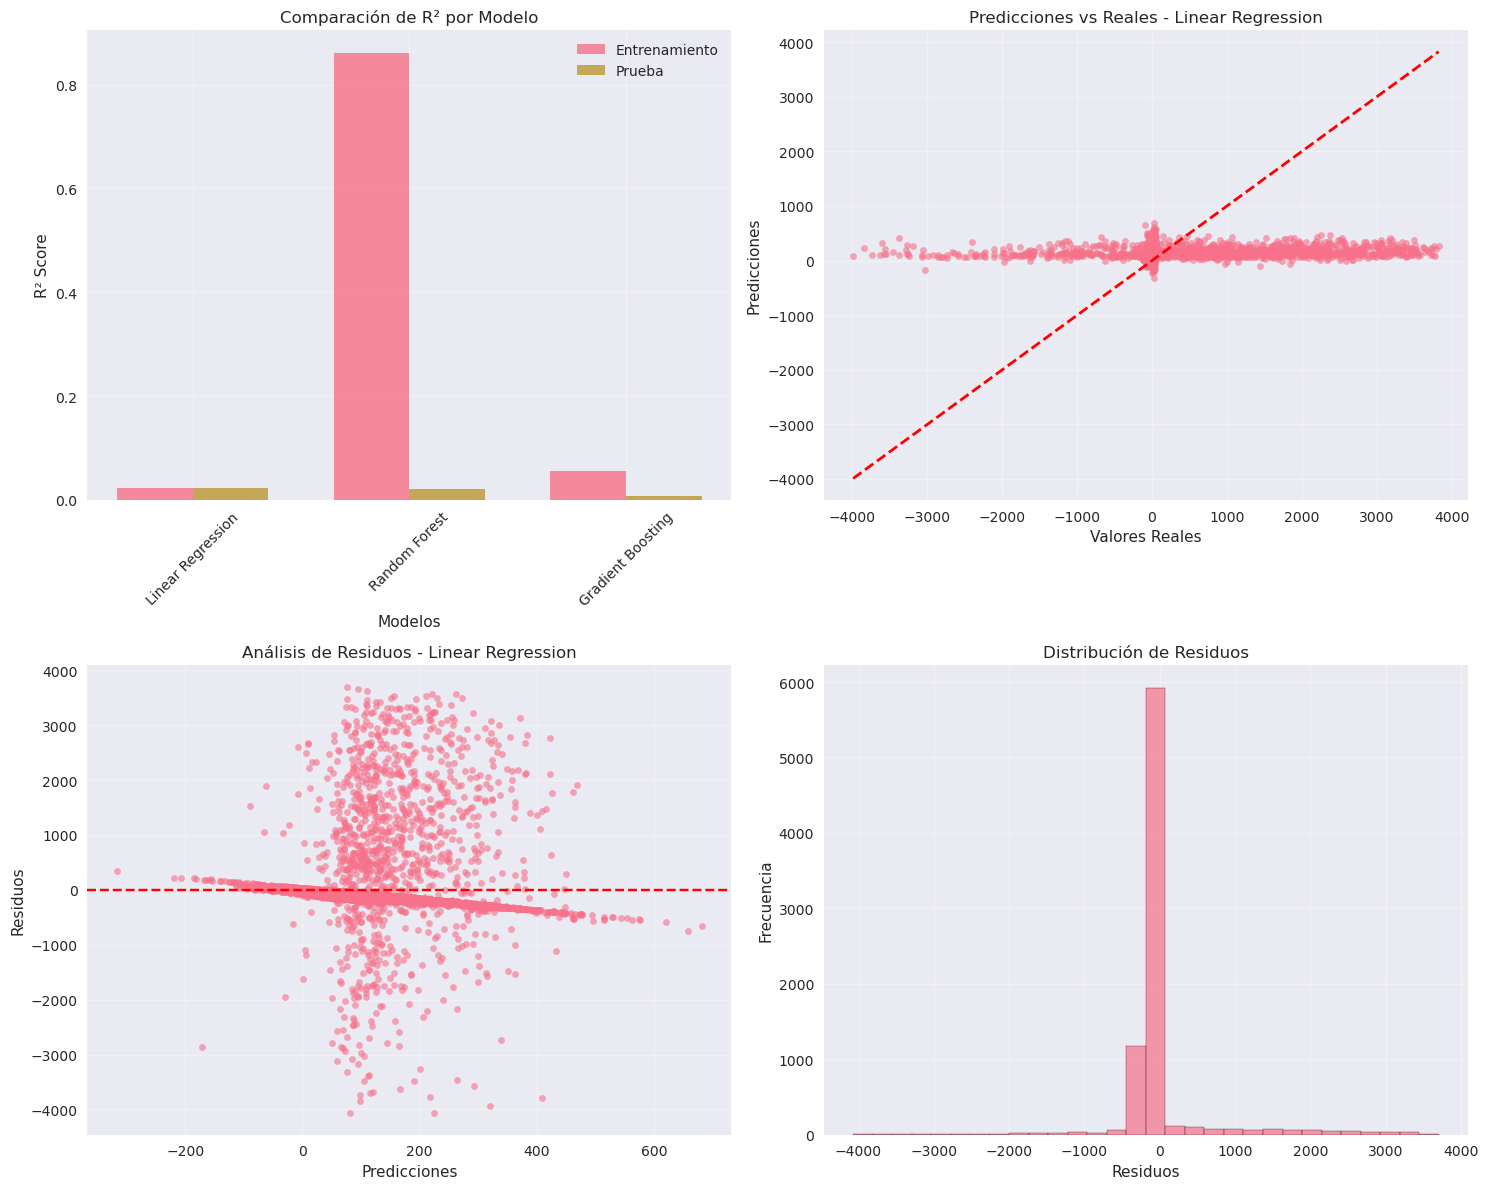

In [130]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Comparación de R²
models_list = list(results.keys())
train_r2_list = [results[model]['train_r2'] for model in models_list]
test_r2_list = [results[model]['test_r2'] for model in models_list]

x = np.arange(len(models_list))
width = 0.35

axes[0, 0].bar(x - width/2, train_r2_list, width, label='Entrenamiento', alpha=0.8)
axes[0, 0].bar(x + width/2, test_r2_list, width, label='Prueba', alpha=0.8)
axes[0, 0].set_xlabel('Modelos')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('Comparación de R² por Modelo')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models_list, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Predicciones vs Valores Reales (mejor modelo)
test_pred_best = results[best_model_name]['test_pred']

axes[0, 1].scatter(y_test, test_pred_best, alpha=0.6, s=20)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Valores Reales')
axes[0, 1].set_ylabel('Predicciones')
axes[0, 1].set_title(f'Predicciones vs Reales - {best_model_name}')
axes[0, 1].grid(True, alpha=0.3)

# Residuos
residuals = y_test - test_pred_best
axes[1, 0].scatter(test_pred_best, residuals, alpha=0.6, s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicciones')
axes[1, 0].set_ylabel('Residuos')
axes[1, 0].set_title(f'Análisis de Residuos - {best_model_name}')
axes[1, 0].grid(True, alpha=0.3)

# Distribución de errores
axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Residuos')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Residuos')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [131]:
# Importancia de características (si disponible)
best_model = trained_models[best_model_name]
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X_train.columns

    # Ordenar por importancia
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title(f'Importancia de Características - {best_model_name}')
    plt.bar(range(min(20, len(importances))), importances[indices[:20]])
    plt.xticks(range(min(20, len(importances))),
              [feature_names[i] for i in indices[:20]],
              rotation=45, ha='right')
    plt.xlabel('Características')
    plt.ylabel('Importancia')
    plt.tight_layout()
    plt.show()
